In [1]:
from tensorflow import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.models import Sequential
from keras.layers.convolutional import ZeroPadding2D
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

## 1- load Images dataset

In [2]:
def append_ext(fn):
    return fn+".jpg"

#loading dataset labels from csv 
df = pd.read_csv("dataset.csv")

df["img"] = df["img"].apply(append_ext)

df = df.replace(np.nan, 0)

# labels names in csv
classes = ['gummy','golden_proportion ','gap','crowding','incisal embrassure ','color','Central line','Crooked','Central Incisor W/H Ratio','Black triangle','perfect']



In [3]:
#shuffle dataframe before splitting 
df=df.sample(frac=1).reset_index(drop=True)

In [4]:
# load images in dataframe from saving directory 
# pationing dataset to 80:10:10 , train:valid:test sets
train_data_generation = ImageDataGenerator(rescale=1./255)

training_set = train_data_generation.flow_from_dataframe(dataframe=df[:155],
                                                         directory="./resized_cropped_teeth",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=8,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(rescale=1./255)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[155:175],
                                                         directory="./resized_cropped_teeth",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=8,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(rescale=1./255)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[175:],
                                                         directory="./resized_cropped_teeth",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=1,
                                                         class_mode="raw",seed=0, shuffle = False)


Found 155 validated image filenames.
Found 20 validated image filenames.
Found 19 validated image filenames.


In [5]:
# Store the data in X_test, y_test variables by iterating over the batches
batch_size =1
X_test, y_test = next(test_set)
for i in range(int(len(test_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(test_set)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)

(19, 224, 224, 3) (19, 11)


### Example image

image labels:
['gummy', 'incisal embrassure ', 'Central Incisor W/H Ratio']


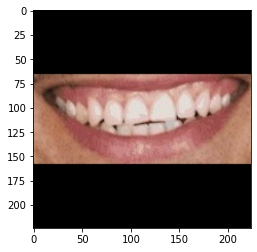

In [6]:
img =next(training_set)
#print(classes)

l=[]
for i, x in enumerate(classes):
    if img[1][0][i]==1 :
        l.append(x)

print("image labels:")
print(l)

img=img[0][0]  #first image
#print(img.shape)
plt.imshow(img)
training_set.reset()

## 2- Model : VGG-16 with pre-trained weights of face recognition task

In [7]:
model = Sequential()
model.add(keras.Input(shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.load_weights('vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model.layers:
    layer.trainable = False

#adding output layers
model.add(Flatten())
model.add( Dense(64, activation='sigmoid', kernel_regularizer=keras.regularizers.L2()))
model.add(Dense(11, activation='sigmoid'))
# summarize

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 222, 222, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 51, 51, 256)       2

In [ ]:
#callbacks
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,verbose = 1, patience=2, mode='auto')
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, mode='auto')

initial_learning_rate = 0.0025
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history=model.fit(x=training_set, validation_data=valid_set, epochs=20 , shuffle =True)


Epoch 1/20
20/20 [==============================] - 18s 872ms/step - loss: 1.1956 - binary_accuracy: 0.6463 - val_loss: 0.7410 - val_binary_accuracy: 0.7182
Epoch 2/20
20/20 [==============================] - 19s 941ms/step - loss: 0.5785 - binary_accuracy: 0.7537 - val_loss: 0.5792 - val_binary_accuracy: 0.7000
Epoch 3/20
 1/20 [>.............................] - ETA: 16s - loss: 0.5060 - binary_accuracy: 0.7727

## Plotting Diagnostic curves

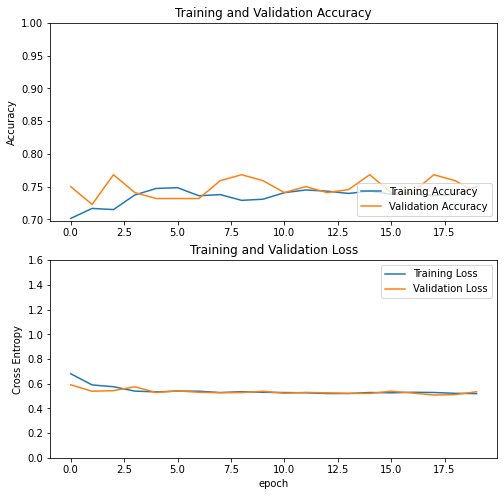

In [18]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
predictions= model.predict(test_set)
y_pred=[]
for pred in predictions:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(predictions)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [41]:
from sklearn.metrics import classification_report

label_names = classes

print(classification_report(y_test, y_pred,target_names=label_names))

                           precision    recall  f1-score   support

                    gummy       0.00      0.00      0.00         1
       golden_proportion        0.67      0.20      0.31        10
                      gap       0.00      0.00      0.00         1
                 crowding       0.00      0.00      0.00         6
      incisal embrassure        0.27      0.38      0.32         8
                    color       0.56      0.56      0.56         9
             Central line       0.00      0.00      0.00         3
                  Crooked       0.00      0.00      0.00         3
Central Incisor W/H Ratio       0.65      0.92      0.76        12
           Black triangle       0.00      0.00      0.00         1
                  perfect       0.00      0.00      0.00         4

                micro avg       0.51      0.36      0.42        58
                macro avg       0.19      0.19      0.18        58
             weighted avg       0.37      0.36      0.34    

c:\users\nkhal\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nkhal\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


true labels : gummy, golden_proportion , crowding, incisal embrassure , color, Central line, Central Incisor W/H Ratio
predicted labels : golden_proportion , incisal embrassure , color, Central Incisor W/H Ratio


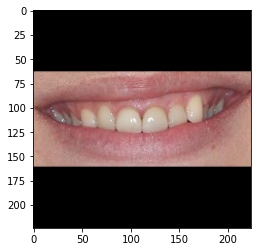

In [45]:
# output sample
true_labels=[]
pred_labels = []

for y ,z  in zip(y_test,y_pred):
    true =[]
    pred =[]
    for i, x in enumerate(classes):
        if y[i]==1 :
            true.append(x)
            
        if z[i]==1 :
            pred.append(x)
    true_labels.append(", ".join(true))
    pred_labels.append(", ".join(pred))
        
#print(test_set.index_array)
print("true labels : "+true_labels[4])
print("predicted labels : "+pred_labels[4])

plt.imshow(X_test[4])

#['gummy', 'golden_proportion ', 'gap', 'crowding', 'incisal embrassure ', 'color', 'Central line', 'Crooked', 'Central Incisor W/H Ratio', 'Black triangle', 'perfect']

In [17]:
model.save("vgg_teeth.h5")